

Network to learn a random matrix -> 1x hardcoded matrix via MLP
----------
Input to network:
tensor([[0.5728, 0.1950],
        [0.8758, 0.5587]], dtype=torch.float64)
Pre-training model output:
 tensor([[ 0.0677, -0.4749],
        [-0.4827, -0.0796]], dtype=torch.float64, grad_fn=<ViewBackward0>)
----------

Trained Model's Output for the random input:
tensor([[0.7429, 0.8446],
        [0.8514, 1.1339]], dtype=torch.float64, grad_fn=<ViewBackward0>)
Desired Tensor:
tensor([[0.7374, 0.8229],
        [0.8229, 1.1626]], dtype=torch.float64)


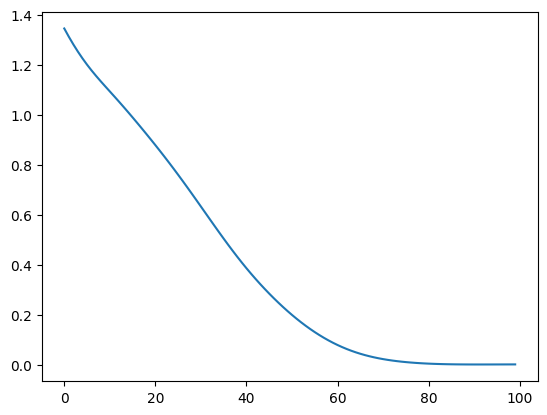

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Randomly generate a symmetric matrix
def generate_symmetric_matrix(dim):
    A = torch.rand(dim, dim, dtype=torch.double)
    return (A + A.t()) / 2

# Ensure the matrix is positive definite
def make_positive_definite(A):
    eigenvalues, _ = torch.linalg.eigh(A)
    if torch.all(eigenvalues > 0):
        return A
    else:
        return A + torch.eye(A.size(0)) * (torch.abs(eigenvalues.min()) + 0.1)

# Simplified MLP definition
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 5)
        self.fc2 = nn.Linear(5, output_dim)

    def forward(self, x):
        x = x.view(-1, 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(2, 2)

# Generate symmetric positive 2x2 tensor
tensor = generate_symmetric_matrix(2)
tensor = make_positive_definite(tensor)

# Initialize model, criterion, and optimizer
model = SimpleMLP(4, 4)  # 4 input dimensions (2x2 matrix flattened) and 4 output dimensions
model.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100

# Generate random input
random_input = torch.rand(2, 2, dtype=torch.double)
pre_train_output = model(random_input)

losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    outputs = model(random_input)
    
    loss = criterion(outputs, tensor)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    # if (epoch+1) % 20 == 0:
    #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


plt.plot(losses)
print("\n\nNetwork to learn a random matrix -> 1x hardcoded matrix via MLP")
print('-'*10)
print(f'Input to network:\n{random_input}')
print(f'Pre-training model output:\n {pre_train_output}')
print('-'*10)
print(f"\nTrained Model's Output for the random input:\n{model(random_input)}")
print(f"Desired Tensor:\n{tensor}")




Network to learn a random input -> 1x hardcoded eigenvector via MLP
excluding the eigh from network
----------
----------

Trained Model's Output for the random input:
tensor([[ 0.3384, -0.9409],
        [-0.9384, -0.3383]], dtype=torch.float64, grad_fn=<ViewBackward0>)
True Eigenvectors:
tensor([[ 0.3379, -0.9412],
        [-0.9412, -0.3379]], dtype=torch.float64)


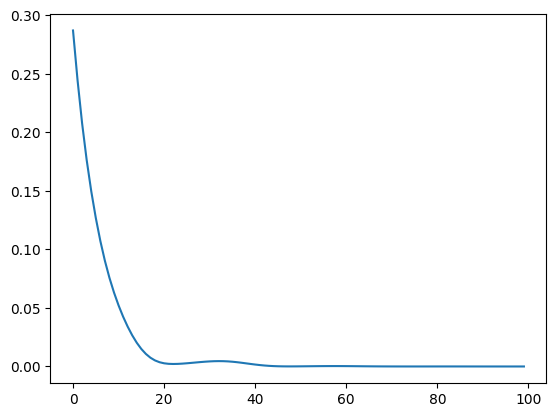

In [2]:
# Simplified MLP definition
class EigenvectorMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EigenvectorMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 5)
        self.fc2 = nn.Linear(5, output_dim)

    def forward(self, x):
        x = x.view(-1, 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(2, 2)

# Generate random input and its eigenvectors
random_input = torch.rand(2, 2, dtype=torch.double)
_, eigenvectors = torch.linalg.eigh(random_input)

# Initialize model, criterion, and optimizer
model = EigenvectorMLP(4, 4)  # 4 input dimensions (2x2 matrix flattened) and 4 output dimensions
model.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100

losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    outputs = model(random_input)
    
    loss = criterion(outputs, eigenvectors)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    # if (epoch+1) % 20 == 0:
    #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

plt.plot(losses)

print("\n\nNetwork to learn a random input -> 1x hardcoded eigenvector via MLP\nexcluding the eigh from network")
print('-'*10)
print('-'*10)
print(f"\nTrained Model's Output for the random input:\n{model(random_input)}")
print(f"True Eigenvectors:\n{eigenvectors}")


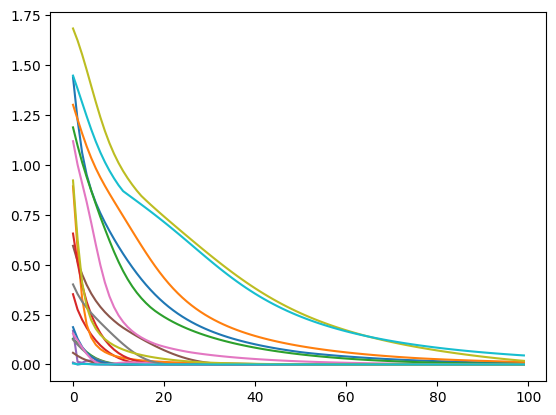

In [3]:
class EigenvectorMLPWithEigh(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EigenvectorMLPWithEigh, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.fc2 = nn.Linear(8, output_dim)

    def forward(self, x):
        x = x.view(-1, 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).view(2, 2)
        symmetric_matrix = (x + x.t()) / 2
        _, eigenvectors = torch.linalg.eigh(symmetric_matrix)
        return eigenvectors[:,1]

# Generate random input and its eigenvectors
random_input = torch.rand(2, 2, dtype=torch.double)

tensor = generate_symmetric_matrix(2)
tensor = make_positive_definite(tensor)
_, target_eigenvectors = torch.linalg.eigh(tensor)
target_eigenvector = target_eigenvectors[:,1]

target_eigenvector = target_eigenvector*target_eigenvector[0].sign()

# Training loop
num_epochs = 100

trials = 20
losses = [[] for i in range(trials)]
for trial in range(trials):
    # Initialize model, criterion, and optimizer
    model = EigenvectorMLPWithEigh(4, 4)  # 4 input dimensions (2x2 matrix flattened) and 4 output dimensions
    model.double()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        outputs = model(random_input)
        outputs = outputs * outputs[0].sign()
        
        loss = criterion(outputs, target_eigenvector)
        loss.backward()
        optimizer.step()

        losses[trial].append(loss.item())
        # if (epoch+1) % 150 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# print('-'*10)
# print(f"\nTrained Model's Output for the random input:\n{model(random_input)}")
# print(f"True Eigenvectors:\n{target_eigenvectors}")

for loss in losses:
    plt.plot(loss)

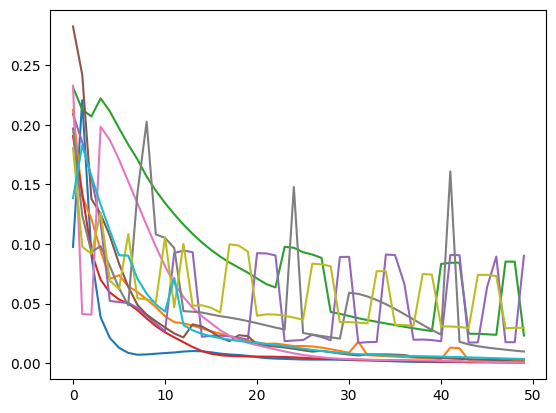

In [4]:
from eigen_decomposition import EigenDecompositionFcn

class EigenvectorMLPWithDDNEigh(nn.Module):
    def __init__(self, dimensions):
        super(EigenvectorMLPWithDDNEigh, self).__init__()
        self.input_dim = dimensions[0] * dimensions[1]
        self.fc1 = nn.Linear(self.input_dim, 8)
        self.fc2 = nn.Linear(8, self.input_dim)
        self.dimensions = dimensions

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).view(*self.dimensions)
        x = x.unsqueeze(0)
        Y = EigenDecompositionFcn.apply(x)
        return Y[:,1]

# Generate random input and its eigenvectors
dimensions = (10, 10)
random_input = torch.rand(*dimensions, dtype=torch.double)
tensor = generate_symmetric_matrix(dimensions[0])
tensor = make_positive_definite(tensor)
_, target_eigenvectors = torch.linalg.eigh(tensor)
target_eigenvector = target_eigenvectors[:,1]
target_eigenvector = target_eigenvector * target_eigenvector[0].sign()

# Training loop
num_epochs = 50
trials = 10
losses = [[] for i in range(trials)]
for trial in range(trials):
    # Initialize model, criterion, and optimizer
    model = EigenvectorMLPWithDDNEigh(dimensions)  
    model.double()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        outputs = model(random_input)[0]
        # NOTE: currently the sign is within the no_grad, but this seems to make it less stable??
        #       question is, is it hitting the failure point of close to 0 -'ve +'ve or something else?
        #       just make a small example and test it? maybe due to accuracies in eigensolver too
        #       probably switch to CPU for the DDN part..
        # outputs = outputs * outputs[0].sign()
        
        loss = criterion(outputs, target_eigenvector)
        loss.backward()
        optimizer.step()

        losses[trial].append(loss.item())

for loss in losses:
    plt.plot(loss)